## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [48]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

b. Use the below cell to find the number of rows in the dataset.

In [4]:
#Returns number of rows and columns
df.shape 

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
# returns number of unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
# returns the proportion of users converted (Average value)
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df2 = df.query("(group == 'treatment' and landing_page == 'old_page') or (group == 'control' and landing_page != 'old_page')") 
df2.shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
# checking missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
#Counts null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# define a new dataframe df2 from, we exclude the 3893 records where new_page and trement didn't line up
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
# number of unique user_ids 
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
#displays the duplicated user_id
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
# Displays the info of the duplicated user_id
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
# drop duplicated row and keeping only the first duplicated value
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# The probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
#Mean average of control group converted
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
#Mean average of treatment group converted
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# The probability that an individual received the new page
new_page_p = (df2['landing_page'] == 'new_page').mean()
new_page_p

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**answer:**

The probability of an individual was in the treatment group that have converted is 0.118808.

The probability of an individual was in the control group that have converted is 0.120386.

The control group converted at a slightly higher rate than the teatment group.

We can find that the old page does better but with small diffrence than the new page.

The results don't provide sufficient evidence if one page leads to more conversions 
as there are more factors that have not been accounted.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

*$H_{0}$ : $p_{old}$ >= $p_{new}$
*

*$H_{1}$ : $p_{new}$ > $p_{old}$
*

H0(Null Hypothesis): New page does same or worse than old page. 

H1(Alternative Hypothesis): New page does better than old page.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
# p_old = p_new = converted rate regardless of the page.
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
# p_old = p_new = converted rate regardless of the page.
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17233

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

-0.001275310174060143

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []

for _ in range(10000):
    new_converted_simulated = np.random.binomial(n_new,p_new)/n_new
    old_converted_simulated = np.random.binomial(n_old,p_old)/n_old
    diff = new_converted_simulated - old_converted_simulated
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

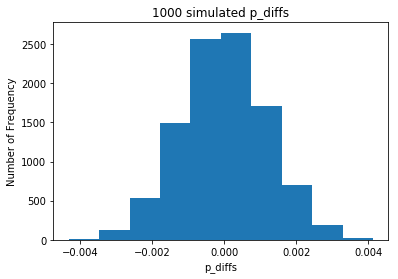

In [31]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Number of Frequency')
plt.title('1000 simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
#Calculate the actual difference

actual_old_mean = df.query('group =="control"').converted.mean()
actual_new_mean = df.query('group =="treatment"').converted.mean()
actual_diff = actual_new_mean - actual_old_mean

#Convert p diffs in to array

p_diffs = np.array(p_diffs)

#Calculate the propotion of the p_diffs are greater than the actual difference 
(p_diffs > actual_diff).mean()

0.8917

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**answer**

The value we are calculating called p-value which is the probability of observing our statistic
that tells if there is a significant difference between two groups whether the null hypothesis is true or not.

The p-value we calculated is greater than alpha level of 0.05. 

so we would fail to reject the null and conclude that there is no statical evidence to say there is a difference between the new and old page so we keep the old page 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [38]:
# tells how significant z-score is
from scipy.stats import norm
print(norm.cdf(z_score))

0.9050583127590245


In [39]:
# we assume at 95% confidence level
print(norm.ppf(1-(0.05)))

1.6448536269514722


**answer**

we found that z-score is less than the critical value of 1.6448536269514722. So, we would fail to reject the Null.

we find that old page better than new page.

The results agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
 #To fit the model
import statsmodels.api as sm
logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results = logit.fit()
results.summary()  #Summary of test results.

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:47:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

Our hypothesis:

$H_{0}$ : $p_{new}$ - $p_{old}$ = 0

$H_{1}$ : $p_{new}$ - $p_{old}$ != 0

**p-value associated with ab_page is 0.19. 
It is different as it is lower than the one in Part II ,in part II we performed one-sided test where in the logistic regression part it is two-sided test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**it will be a good idea to add some additional factors that may provide better test results such as duration of testing.**

**The disadvantages of adding additional factors into the regression model is that it may produce inaccurate results due to correlated errors or outlier so we need to take them into account.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [44]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 May 2019   Pseudo R-squ.:                 -0.2214
Time:                        10:03:45   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

In part II and part III, p-value changed but both we fail to reject the null hypothesis. 

Conversion rate for old page is better than new one. 

In the analysis  I found that the old page was better than the new page.so The company shouldn't implement new page and keep the old page.

There is no significant impact of the countries and new page on conversion rates.